In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7420110692130371091
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15471094691082497381
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2, _range=None):
    return compare_ssim(img1, img2, data_range=_range)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
"""
    basic CNN model
"""
def SRCNN(pretrained_weights=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(512, 512, 1),padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    if(pretrained_weights):
            model.load_weights(pretrained_weights)

    return model

In [4]:
"""
    load validation data
"""
import gc

dataY = np.zeros((400,512, 512))

count = 0
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    dataY[count] = img
    dataY[count+1] = img
    dataY[count+2] = img
    dataY[count+3] = img
    dataY[count+4] = img
    count += 5
    
dataY = dataY.reshape(-1, 512, 512, 1)
dataY = dataY.astype('float32') / 255

In [6]:
"""
    noise image
"""
X = np.zeros((400,512, 512))

count = 0
for i in range(1, 81):
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise50.png", cv2.IMREAD_GRAYSCALE)
    X[count] = img
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise60.png", cv2.IMREAD_GRAYSCALE)
    X[count+1] = img
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise70.png", cv2.IMREAD_GRAYSCALE)
    X[count+2] = img
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise80.png", cv2.IMREAD_GRAYSCALE)
    X[count+3] = img
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + "_noise90.png", cv2.IMREAD_GRAYSCALE)
    X[count+4] = img
    count += 5

X = X.reshape(-1, 512, 512, 1)
X = X.astype('float32') / 255

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None
== SRCNN 80 ==
loss: 0.014597864858806132
accuracy: 0.0


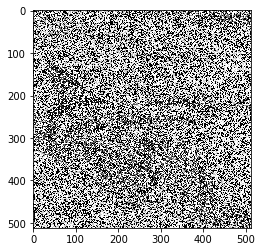

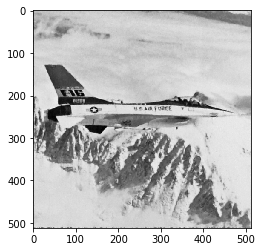

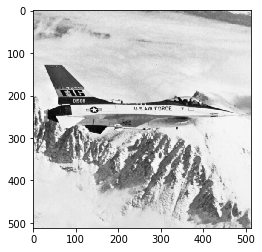

31.295413970947266
23.513610020279884
0.9649048079881938
0.728462092400822


In [9]:
model = SRCNN("SRCNN_0415.h5")
print("== SRCNN 80 ==")
X = X.reshape(-1, 512, 512, 1)
dataY = dataY.reshape(-1, 512, 512, 1)
score = model.evaluate(X, dataY, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

result = model.predict(X)
result = result.reshape(-1, 512, 512)
X = X.reshape(-1, 512, 512)
dataY = dataY.reshape(-1, 512, 512)

img = X[7]
plt.imshow(img, cmap="gray")
plt.show()

img = result[7]
plt.imshow(img, cmap="gray")
plt.show()

img = dataY[7]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(dataY[7], result[7]) )

totalPSNR = 0
for i in range(400):
    totalPSNR += PSNR(dataY[i], result[i])
#print(totalPSNR)
print(totalPSNR / 400)

totalSSIM = 0
for i in range(400):
    totalSSIM += SSIM(dataY[i], result[i], 1.0)
print(SSIM(dataY[7], result[7]))
print(totalSSIM / 400)

count = 0
for i in range(80):
    img = result[count]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80/" + str(i+1) + '_denoise50.bmp', img)
    img = result[count+1]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80/" + str(i+1) + '_denoise60.bmp', img)
    img = result[count+2]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80/" + str(i+1) + '_denoise70.bmp', img)
    img = result[count+3]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80/" + str(i+1) + '_denoise80.bmp', img)
    img = result[count+4]
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    cv2.imwrite("../../Denoise_80/" + str(i+1) + '_denoise90.bmp', img)
    count+=5


In [16]:
print(PSNR(dataY[0], result[0]) )
print(SSIM(dataY[0], result[0]))

21.95263385772705
0.7027307208043155


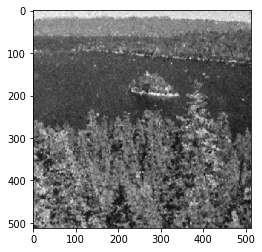

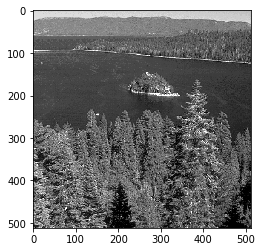

1 21.93939311084677
2 23.907785132179683
3 21.105379292775808
4 12.88812636544042
5 18.67733269179555
6 22.861921844867773
7 18.727085878813025
8 20.272330063236442
9 19.523690986862587
10 16.170698027305235
11 16.59181663869295
12 20.481340890780423
13 25.262047747841343
14 22.491324948832705
15 24.456834152972675
16 21.02800275458889
17 26.83265474483091
18 25.795426820396816
19 25.672221822536955
20 26.985779385381555
21 23.200467179790106
22 25.9786078588127
23 19.695840878536178
24 20.969144009655906
25 17.720724419349956
26 22.01406319247496
27 20.162217237586347
28 21.66850664352812
29 24.37199699950665
30 15.807082996477057
31 28.42987591328375
32 15.721434003533371
33 23.557419598724817
34 21.92458127519528
35 21.29028980166227
36 22.43144960204956
37 15.0285613627399
38 23.289803874892026
39 24.278098730476803
40 11.745564429018282
41 20.665917029400926
42 26.011093505608173
43 17.958181384243073
44 23.708015836953464
45 26.940746905491714
46 28.555081417775842
47 24.79186283

In [17]:
from skimage import img_as_float
from skimage import img_as_ubyte
X = np.zeros((80,512, 512), dtype=np.uint8)
Y = np.zeros((80,512, 512), dtype=np.uint8)

for i in range(1, 81):
    picture = str(i)
    img = cv2.imread("../../Denoise_80/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    X[i-1] = img
    picture = f'{i:#04d}'
    img = cv2.imread("../../Gray-Level_80_noise/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    Y[i-1] = img

#X = X.astype('float') / 255
#Y = Y.astype('float') / 255
                 
img = X[7]
plt.imshow(img, cmap="gray")
plt.show()

img = Y[7]
plt.imshow(img, cmap="gray")
plt.show()
totalPSNR = 0
for i in range(80):
    totalPSNR += PSNR(img_as_float(Y[i]), img_as_float(X[i]))
    print(i+1, PSNR(img_as_float(Y[i]), img_as_float(X[i])))
print(totalPSNR/80)
                 

print("=========")
totalSSIM = 0
for i in range(80): 
    #totalSSIM += SSIM(Y[i], X[i]) #0.5114699011236234
    #print(i+1, SSIM(Y[i], X[i]) )
                 
    #totalSSIM += SSIM(img_as_ubyte(img_as_float(Y[i])), img_as_ubyte(img_as_float(X[i]))) #0.5114699011236234
    #print(i+1, SSIM(img_as_ubyte(img_as_float(Y[i])), img_as_ubyte(img_as_float(X[i]))) ) 
                 
    #totalSSIM += SSIM(img_as_float(Y[i]), img_as_float(X[i])) #0.6623636208041587
    #print(i+1, SSIM(img_as_float(Y[i]), img_as_float(X[i])) )
                 
    totalSSIM += SSIM(img_as_float(Y[i]), img_as_float(X[i]), 1.0) #0.5114699011236248
    print(i+1, SSIM(img_as_float(Y[i]), img_as_float(X[i]), 1.0) )
print(totalSSIM/80)

In [78]:
from skimage import io, measure
image = np.arange(0, 100, 10, dtype=np.uint8)
image2 = np.arange(0, 50, 5, dtype=np.uint8)
print(measure.compare_ssim(image, image2))
print(measure.compare_ssim(img_as_float(image), img_as_float(image2)))



0.6551000017326546
0.6879391266026805


In [ ]:
from skimage import img_as_float
from skimage import img_as_ubyte
X = np.zeros((80,512, 512), dtype=np.uint8)
Y = np.zeros((80,512, 512), dtype=np.uint8)

for i in range(1, 81):
    img = cv2.imread("...", cv2.IMREAD_GRAYSCALE)
    X[i-1] = img
    img = cv2.imread("...", cv2.IMREAD_GRAYSCALE)
    Y[i-1] = img

for i in range(80): 
    #totalSSIM += measure.compare_ssim(Y[i], X[i]) #0.5114699011236234
    #print(i+1, measure.compare_ssim(Y[i], X[i]) )
                 
    #totalSSIM += measure.compare_ssim(img_as_ubyte(img_as_float(Y[i])), img_as_ubyte(img_as_float(X[i]))) #0.5114699011236234
    #print(i+1, measure.compare_ssim(img_as_ubyte(img_as_float(Y[i])), img_as_ubyte(img_as_float(X[i]))) ) 
                 
    #totalSSIM += measure.compare_ssim(img_as_float(Y[i]), img_as_float(X[i])) #0.6623636208041587
    #print(i+1, measure.compare_ssim(img_as_float(Y[i]), img_as_float(X[i])) )
                 
    totalSSIM += measure.compare_ssim(img_as_float(Y[i]), img_as_float(X[i]), data_range=1.0) #0.5114699011236248
    print(i+1, measure.compare_ssim(img_as_float(Y[i]), img_as_float(X[i]), data_range=1.0) )
print(totalSSIM/80)